### Importing and Understanding Data

## Model Selection using RFE(HOUSING CASE STUDY)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import metrics

In [34]:
# Importing Housing.csv
df = pd.read_csv(r"https://raw.githubusercontent.com/lit-infinity/house-price-prediction/main/Housing.csv")

In [35]:
# Looking at the first five rows
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### Data Preparation

In [36]:
# Converting Yes to 1 and No to 0
df['mainroad'] = df['mainroad'].map({'yes': 1, 'no': 0})
df['guestroom'] = df['guestroom'].map({'yes': 1, 'no': 0})
df['basement'] = df['basement'].map({'yes': 1, 'no': 0})
df['hotwaterheating'] = df['hotwaterheating'].map({'yes': 1, 'no': 0})
df['airconditioning'] = df['airconditioning'].map({'yes': 1, 'no': 0})
df['prefarea'] = df['prefarea'].map({'yes': 1, 'no': 0})

In [5]:
# Creating dummy variable for variable furnishingstatus and dropping the first one
status = pd.get_dummies(df['furnishingstatus'],drop_first=True)

In [37]:
#Adding the results to the master dataframe
housing = pd.concat([df,status],axis=1)

In [38]:
# Dropping the variable 'furnishingstatus'
housing.drop(['furnishingstatus'],axis=1,inplace=True)

#### Creating a new variable

In [39]:
# Let us create the new metric and assign it to "areaperbedroom"
housing['areaperbedroom'] = housing['area']/housing['bedrooms']

In [40]:
# Metric: bathrooms per bedroom
housing['bbratio'] = housing['bathrooms']/housing['bedrooms']

In [10]:
#defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
housing = housing.apply(normalize)

### Splitting data into training and testing sets

In [11]:
# Putting feature variable to X
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]

# Putting response variable to y
y = housing['price']

In [41]:
#random_state is the seed used by the random number generator, it can be any integer.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=101)

In [42]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### RFE

In [43]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [44]:
# Running RFE with the output number of the variable equal to 9
lr = LinearRegression()
rfe = RFE(lr, 9)             # running RFE
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)  

[ True False  True  True False False False  True  True  True  True False
  True  True False]
[1 3 1 1 5 6 4 1 1 1 1 7 1 1 2]


C:\Users\asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [46]:
columns = X_train.columns[rfe.support_]

In [47]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[columns]

In [48]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [49]:
lr = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [50]:
#Let's see the summary of our linear model
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     90.85
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           3.34e-88
Time:                        16:44:30   Log-Likelihood:                 370.18
No. Observations:                 381   AIC:                            -720.4
Df Residuals:                     371   BIC:                            -680.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0769      0.013     

In [51]:
# Calculating Vif value
vif_cal(input_data=housing.drop(['area','bedrooms','stories','basement','semi-furnished','areaperbedroom'], axis=1), dependent_col="price")

,Var,Vif
8,bbratio,17.45
0,bathrooms,17.18
1,mainroad,5.20
5,parking,1.84
4,airconditioning,1.63
7,unfurnished,1.43
6,prefarea,1.42
2,guestroom,1.29
3,hotwaterheating,1.09


In [52]:
# Now let's use our model to make predictions.

# Creating X_test_6 dataframe by dropping variables from X_test
X_test_rfe = X_test[columns]

# Adding a constant variable 
X_test_rfe = sm.add_constant(X_test_rfe)

# Making predictions
y_pred = lr.predict(X_test_rfe)

Text(0, 0.5, 'Housing Price')

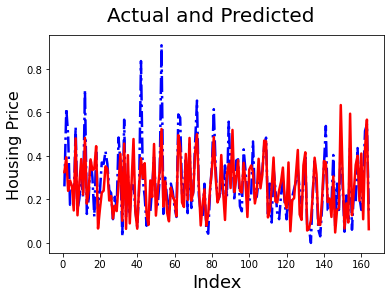

In [55]:
# Actual and Predicted
import matplotlib.pyplot as plt
c = [i for i in range(1,165,1)] # generating index 
fig = plt.figure() 
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-.") #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Housing Price', fontsize=16)                       # Y-label

Text(0, 0.5, 'ytest-ypred')

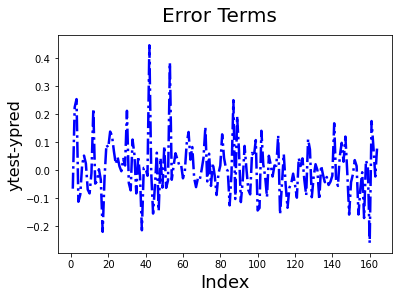

In [56]:
# Error terms
c = [i for i in range(1,165,1)]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-.")
fig.suptitle('Error Terms', fontsize=20)               
plt.xlabel('Index', fontsize=18)                      
plt.ylabel('ytest-ypred', fontsize=16)                

Text(0, 0.5, 'y_pred')

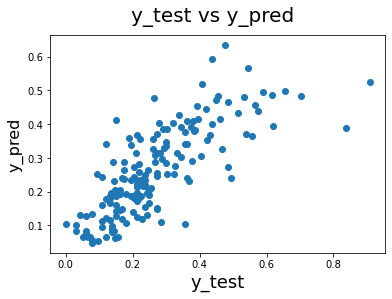

In [60]:

fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)               
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred', fontsize=16)                          

Text(0, 0.5, 'Index')

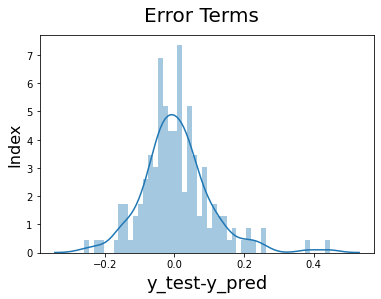

In [61]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  
plt.xlabel('y_test-y_pred', fontsize=18)                  
plt.ylabel('Index', fontsize=16)                        

In [63]:

print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.09988078508557048
